# **Trabalho 3 - Uso de Técnicas de ML Aplicadas em Trading Sistemático**

- **Aluno:** Guilherme Henrique Galdini Tosi
- **N°USP**: 11781587
- **Disciplina**: SSC0964
- **Prof°**: Denis Fernando Wolf

## {SETUP} Bibliotecas Utilizadas

Para a resolução do trabalho, foram utilizadas as bibliotecas pandas, numpy,
ta, yfinance e sklearn:

In [84]:
!pip install ta

In [85]:
!pip install yfinance --upgrade --no-cache-dir

In [86]:
import numpy as np
import pandas as pd

from ta.momentum import RSIIndicator
from ta.volume import MFIIndicator
from ta.trend import MACD

import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning

## {SETUP} Ativos Considerados

- Para elaborar uma lista de ações a serem avaliadas, deu-se ênfase na diversificação dos setores de atuação das empresas com exceção da seleção de ações de dois bancos. Sendo assim, considerando o período de análise de 10 de Outubro de 2002 a 31 de dezembro de 2022, foram selecionadas as seguintes ações:

  ```
  - MGLU3 (Magazine Luiza);
  - VALE3 (Vale);
  - VIVT3 (Telefônica);
  - ITUB4 (Itaú);
  - BBAS3 (Banco do Brasil).

  ```

## {SETUP} Explicações - Estratégias de Aprendizado

### As ações foram avaliadas individualmente para definir uma estratégia de trading sistemático com base na classificação de algoritmos de aprendizado de máquina. Esses algoritmos consideraram diferentes indicadores de entrada, respectivamente, momentum, volume e tendência:

```
Relative Strength Index(RSI)
Money Flow Index(MFI)
Moving Average Convergence Divergence(MACD)
```

### Para estabelecer uma referência a ser seguida, foram definidas janelas de 11 dias, dentro das quais foram calculados os pontos de mínimo(compra ideal) e de máximo(venda ideal) da ação.

#### Os algoritmos de ML foram encarregados de combinar as informações desses indicadores para tomar decisões de compra e venda de ações. Durante o período de análise, foram realizados diversos treinamentos, com partições de 400 dias, dos quais 150 dias foram destinados ao treinamento e 250 dias aos testes.

### Os valores dos indicadores foram convertidos para a mesma ordem de grandeza, com o objetivo de simplificar o processo de treinamento.

## {SETUP} Funções Utilizadas

In [87]:
def get_input_params(dataset):
    rsi_index = RSIIndicator(close=dataset['Close'], window=24, fillna=True)
    dataset['rsi_r'] = rsi_index.rsi() / 100.0

    mfi_index = MFIIndicator(high=dataset['High'], low=dataset['Low'], close=dataset['Close'], volume=dataset['Volume'], window=24, fillna=True)
    dataset['mfi_r'] = mfi_index.money_flow_index() / 100.0

    ind_macd = MACD(close=dataset['Close'], window_slow=24, window_fast=12, fillna=True)
    dataset['macd'] = ind_macd.macd()

    return dataset[['rsi_r', 'mfi_r', 'macd']].reset_index().drop(['Date'], axis=1).to_numpy()

# ordem para comprar -> 1
# ordem para manter -> 0
# ordem para vender -> -1

def get_output_params(dataset):
    # Criação da coluna "Action" para decisões:
    dataset['Action'] = 0

    # Inicialização de variáveis auxiliares:
    start = 0
    window_lenght = 11
    end = start + window_lenght
    tot_data = dataset.shape[0]

    # Definição dos pontos de compra e venda ideais:
    while end < tot_data:
        min = dataset['Close'].iloc[start:end].min()
        max = dataset['Close'].iloc[start:end].max()
        for partition_idx in range(start, end + 1):
            if dataset['Close'].iloc[partition_idx] == min:
                dataset.loc[dataset.index[partition_idx], 'Action'] = 0
                dataset.loc[dataset.index[partition_idx + 1], 'Action'] = 1
            elif dataset['Close'].iloc[partition_idx] == max:
                dataset.loc[dataset.index[partition_idx], 'Action'] = 0
                dataset.loc[dataset.index[partition_idx + 1], 'Action'] = -1
        start = end + 1
        end = start + window_lenght

    return dataset['Action'].reset_index().drop(['Date'], axis=1).to_numpy()

def train(input, output, clf, dataframe):
    # Definição do tamanho de cada partição e criação de coluna:
    dataframe['ML-Action'] = 0
    partition_len = 450
    train = 200 #250 para teste

    # Cálculo da quantidade de partições, sendo treinos e testes
    tot_partitions = input.shape[0] // partition_len

    # variáveis auxiliares para exibição de acurácia e lista de ativos finais:
    sum_train_acc = 0
    sum_test_acc = 0
    actives = []

    # Treino e teste por partição:
    for partition in range(tot_partitions):
        partition_idx = partition * partition_len

        # criação de dataframes para treino e teste
        train_input = input[partition_idx:partition_idx+train]
        train_output = output[partition_idx+1:partition_idx+train+1]

        test_input = input[partition_idx + train:partition_idx + partition_len]
        test_output = output[partition_idx + train + 1:partition_idx + partition_len + 1]

        # Treino do modelo:
        clf.fit(train_input, train_output.ravel());

        # Avaliação dos resultados do df de teste e treinamento
        predicted_train_data = clf.predict(train_input)
        sum_train_acc += metrics.accuracy_score(train_output, predicted_train_data)

        predicted_test_data = clf.predict(test_input)
        sum_test_acc += metrics.accuracy_score(test_output, predicted_test_data)

        actives = np.append(actives, predicted_train_data)
        actives = np.append(actives, predicted_test_data)

    # Exibição da média das acurácias em treinos e testes:
    print("Train's mean accuracy: ", round(sum_train_acc / tot_partitions, 2))
    print("Test's mean accuracy: ", round(sum_test_acc / tot_partitions, 2))

    actives = np.append(actives, [0] * (dataframe.shape[0] % partition_len))
    dataframe['ML-Action'] = actives

def eval_trade_result(dataset, initial_capital, active, algorithm):

    # incializaão de variáveis auxiliares
    dataset['Balance'] = 0
    balance = initial_capital
    opt = 0
    total_trades = 0
    total_greens = 0
    mean_greens = 0
    mean_reds = 0

    # Registro do valor do balance:
    for partition_idx in range(dataset.shape[0]):
        if dataset['ML-Action'].iloc[partition_idx] == 1 and opt == 0:
            transaction_value = dataset['Close'].iloc[partition_idx]
            opt = 1
        elif dataset['ML-Action'].iloc[partition_idx] == 1 and opt == -1:
            transaction_return = transaction_value / dataset['Close'].iloc[partition_idx] - 1
            if transaction_return > 0:
                total_greens += 1
                mean_greens += transaction_return
            else:
                mean_reds += transaction_return
            balance *= (1 + transaction_return)
            total_trades += 1
            opt = 0
        elif dataset['ML-Action'].iloc[partition_idx] == -1 and opt == 0:
            transaction_value = dataset['Close'].iloc[partition_idx]
            opt = -1
        elif dataset['ML-Action'].iloc[partition_idx] == -1 and opt == 1:
            transaction_return = dataset['Close'].iloc[partition_idx] / transaction_value - 1
            if transaction_return > 0:
                total_greens += 1
                mean_greens += transaction_return
            else:
                mean_reds += transaction_return
            balance *= (1 + transaction_return)
            total_trades += 1
            opt = 0
        dataset.loc[dataset.index[partition_idx], 'Balance'] = balance

    # Impressão de informações sobre as operações realizadas:
    if total_greens > 0:
        print(f"Total Trades: {total_trades}, Green trades: {total_greens} ({round(total_greens / total_trades * 100, 2)}%)")
        print(f"Green trades's mean return: {round(mean_greens / total_greens * 100, 2)}%, Red trades's mean return: {round(mean_reds / (total_trades - total_greens) * 100, 2) if total_greens != total_trades else 0}%")
        print(f"Rentability buy and hold: {round((dataset['Close'].iloc[-1] / dataset['Close'].iloc[0] - 1) * 100, 2)}%, Rentability ML trade: {round((dataset['Balance'].iloc[-1] / dataset['Balance'].iloc[0] - 1) * 100, 2)}%\n")
    else:
        print("There weren't trades made in this period!\n")

    # gráfico da curva de capital:
    dataset[['Close', 'Balance']] = dataset[['Close', 'Balance']] / dataset[['Close', 'Balance']].iloc[0] * 100
    dataset[['Close', 'Balance']].iloc[0:].plot(figsize = (15,5), title=f'Capital Curve {active} - {algorithm}');

## {PASSO 1} Download das ações

In [88]:
start = '2002-10-10'
end = '2022-12-31'

# ativos escolhidos
actives = ['MGLU3.SA', 'VALE3.SA', 'VIVT3.SA', 'ITUB4.SA', 'BBAS3.SA']
actives_data = {}

# armazenando dados históricos de cada ativos com base em start e end
for active in actives:
    historic = yf.download(active, start, end, '1d')
    actives_data[active] = historic[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    for index, row in actives_data[active].iterrows():
        actives_data[active].at[index, 'High'] = row['High'] / row['Close'] * row['Adj Close']
        actives_data[active].at[index, 'Low'] = row['Low'] / row['Close'] * row['Adj Close']
        actives_data[active].at[index, 'Close'] = row['Adj Close']

# Criar DataFrame para cada ação
dict_of_active_dfs = {active: pd.DataFrame(actives_data[active]) for active in actives_data}

df_mglu = dict_of_active_dfs['MGLU3.SA']
df_vale3 = dict_of_active_dfs['VALE3.SA']
df_vivt3 = dict_of_active_dfs['VIVT3.SA']
df_itub4 = dict_of_active_dfs['ITUB4.SA']
df_bbas3 = dict_of_active_dfs['BBAS3.SA']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# {PASSO 2} Análises por Ativo

## Magazine Luiza - MGLU3


#### Obtenção dos Dados de Entrada e Saída

In [89]:
data_input = get_input_params(df_mglu)
data_output = get_output_params(df_mglu)

print(f"## INPUT SIZE: {data_input.shape} ##\n## OUTPUT SIZE: {data_output.shape} ##")

## INPUT SIZE: (2898, 3) ##
## OUTPUT SIZE: (2898, 1) ##


#### Classificador Multilayer Perceptron

In [90]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15, ), max_iter=1000000, random_state=1, activation='tanh')
train(data_input, data_output, mlp, df_mglu)

Train's mean accuracy:  0.92
Test's mean accuracy:  0.53


Total Trades: 75, Green trades: 62 (82.67%)
Green trades's mean return: 21.29%, Red trades's mean return: -16.53%
Rentability buy and hold: 478.72%, Rentability ML trade: 122822.64%



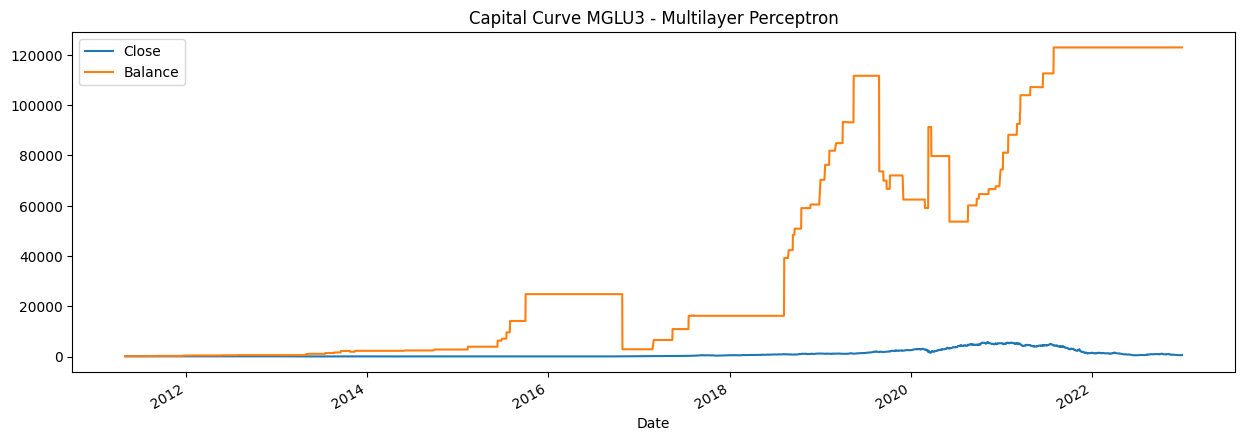

In [91]:
eval_trade_result(df_mglu, 100, 'MGLU3', 'Multilayer Perceptron')

#### Classificador Random Forest

In [92]:
rf = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=5)
train(data_input, data_output, rf, df_mglu)

Train's mean accuracy:  0.9
Test's mean accuracy:  0.73


Total Trades: 39, Green trades: 29 (74.36%)
Green trades's mean return: 23.68%, Red trades's mean return: -25.67%
Rentability buy and hold: 478.72%, Rentability ML trade: 491.11%



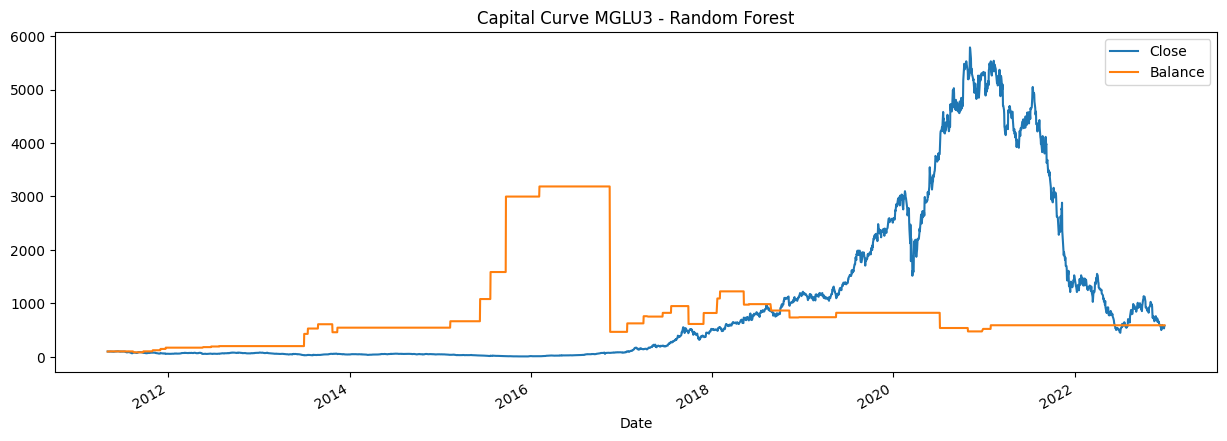

In [93]:
eval_trade_result(df_mglu, 100, 'MGLU3', 'Random Forest')

## Vale - VALE3


#### Obtenção dos Dados de Entrada e Saída

In [94]:
input_data = get_input_params(df_vale3)
output_data = get_output_params(df_vale3)

print(f"## INPUT SIZE: {input_data.shape} ##\n## OUTPUT SIZE: {output_data.shape} ##")

## INPUT SIZE: (5055, 3) ##
## OUTPUT SIZE: (5055, 1) ##


#### Classificador Multilayer Perceptron

In [95]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15, ), max_iter=1000000, random_state=1, activation='tanh')
train(input_data, output_data, mlp, df_vale3)

Train's mean accuracy:  0.92
Test's mean accuracy:  0.67


Total Trades: 116, Green trades: 92 (79.31%)
Green trades's mean return: 13.0%, Red trades's mean return: -10.68%
Rentability buy and hold: 2395.63%, Rentability ML trade: 190365.86%



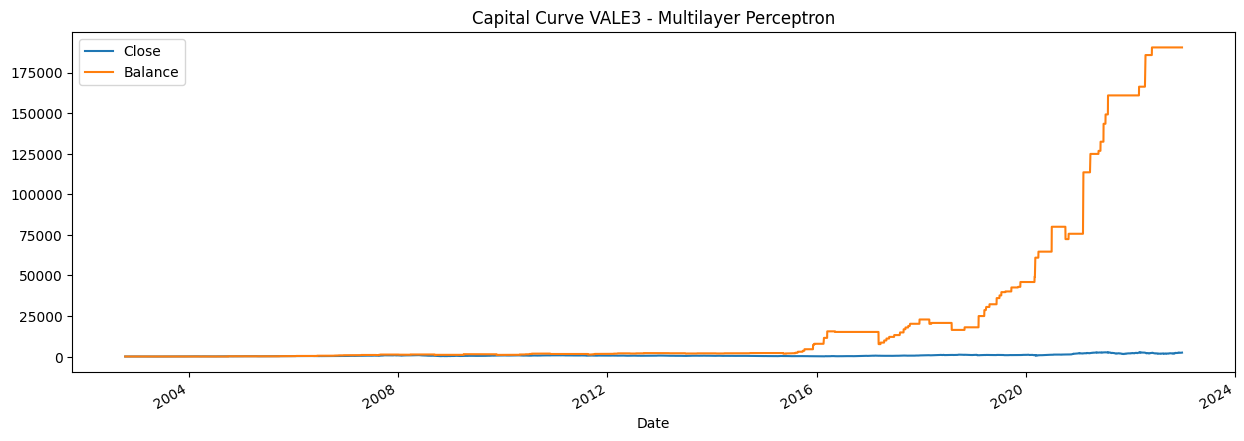

In [96]:
eval_trade_result(df_vale3, 100, 'VALE3', 'Multilayer Perceptron')

#### Classificador Random Forest

In [97]:
rf = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=5)
train(input_data, output_data, rf, df_vale3)

Train's mean accuracy:  0.89
Test's mean accuracy:  0.75


Total Trades: 70, Green trades: 57 (81.43%)
Green trades's mean return: 19.22%, Red trades's mean return: -12.53%
Rentability buy and hold: 2395.63%, Rentability ML trade: 129189.39%



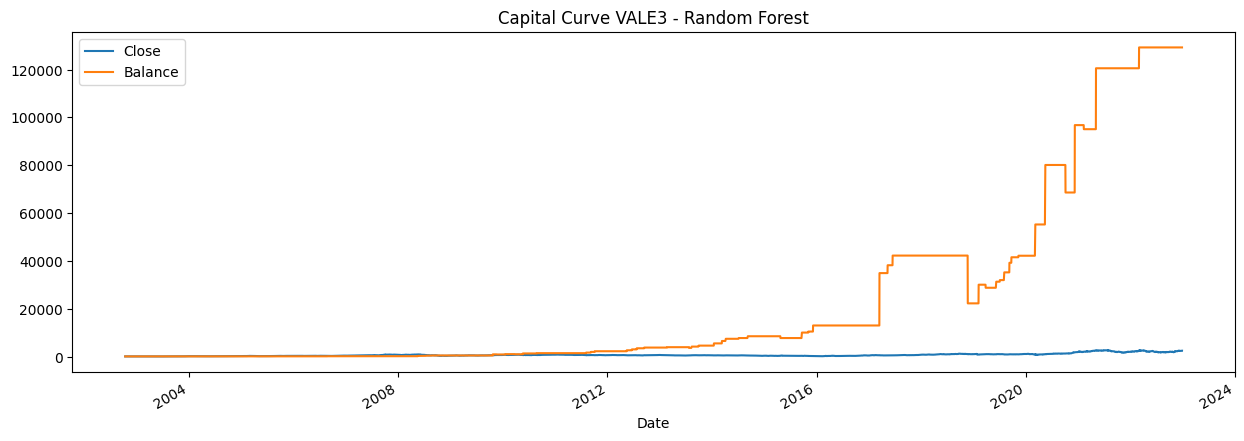

In [98]:
eval_trade_result(df_vale3, 100, 'VALE3', 'Random Forest')

## Telefônica - VIVT3

In [99]:
input_data = get_input_params(df_vivt3)
output_data = get_output_params(df_vivt3)

print(f"## INPUT SIZE: {input_data.shape} ##\n## OUTPUT SIZE: {output_data.shape} ##")

## INPUT SIZE: (5055, 3) ##
## OUTPUT SIZE: (5055, 1) ##


#### Classificador Multilayer Perceptron

In [100]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15, ), max_iter=1000000, random_state=1, activation='tanh')
train(input_data, output_data, mlp, df_vivt3)

Train's mean accuracy:  0.91
Test's mean accuracy:  0.65


Total Trades: 186, Green trades: 149 (80.11%)
Green trades's mean return: 5.99%, Red trades's mean return: -5.14%
Rentability buy and hold: 468.26%, Rentability ML trade: 68947.81%



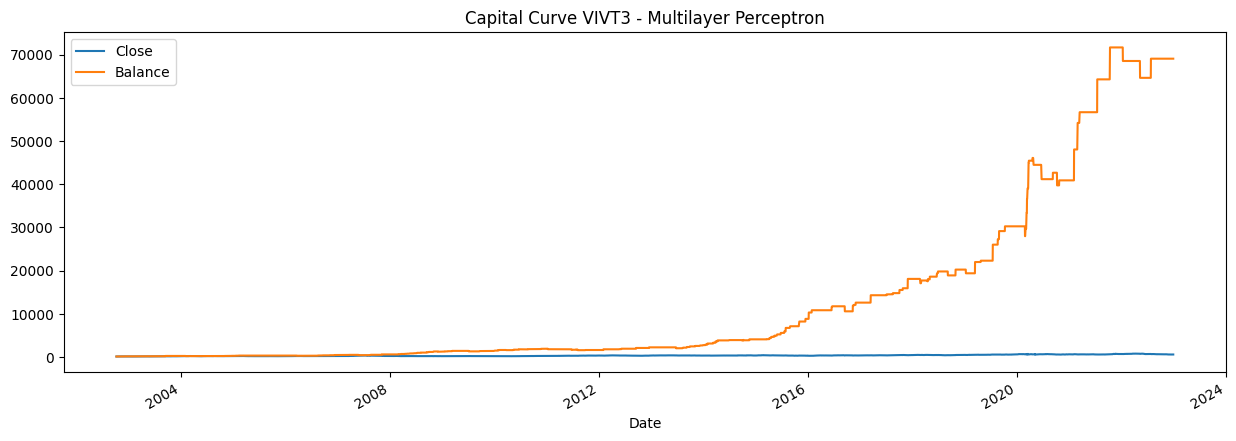

In [101]:
eval_trade_result(df_vivt3, 100, 'VIVT3', 'Multilayer Perceptron')

#### Classificador Random Forest

In [102]:
rf = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=5)
train(input_data, output_data, rf, df_vivt3)

Train's mean accuracy:  0.9
Test's mean accuracy:  0.72


Total Trades: 76, Green trades: 63 (82.89%)
Green trades's mean return: 8.74%, Red trades's mean return: -9.16%
Rentability buy and hold: 468.26%, Rentability ML trade: 4670.81%



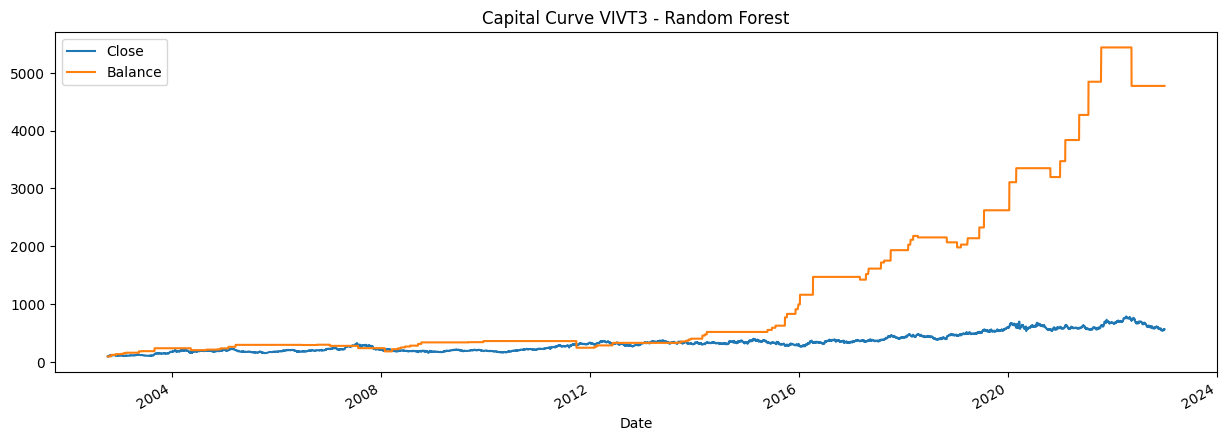

In [103]:
eval_trade_result(df_vivt3, 100, 'VIVT3', 'Random Forest')

## Itaú - ITUB4


#### Obtenção dos Dados de Entrada e Saída

In [104]:
input_data = get_input_params(df_itub4)
output_data = get_output_params(df_itub4)

print(f"## INPUT SIZE: {input_data.shape} ##\n## OUTPUT SIZE: {output_data.shape} ##")

## INPUT SIZE: (5055, 3) ##
## OUTPUT SIZE: (5055, 1) ##


#### Classificador Multilayer Perceptron

In [105]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15, ), max_iter=1000000, random_state=1, activation='tanh')
train(input_data, output_data, mlp, df_itub4)

Train's mean accuracy:  0.91
Test's mean accuracy:  0.62


Total Trades: 181, Green trades: 137 (75.69%)
Green trades's mean return: 8.87%, Red trades's mean return: -5.64%
Rentability buy and hold: 1958.06%, Rentability ML trade: 548712.35%



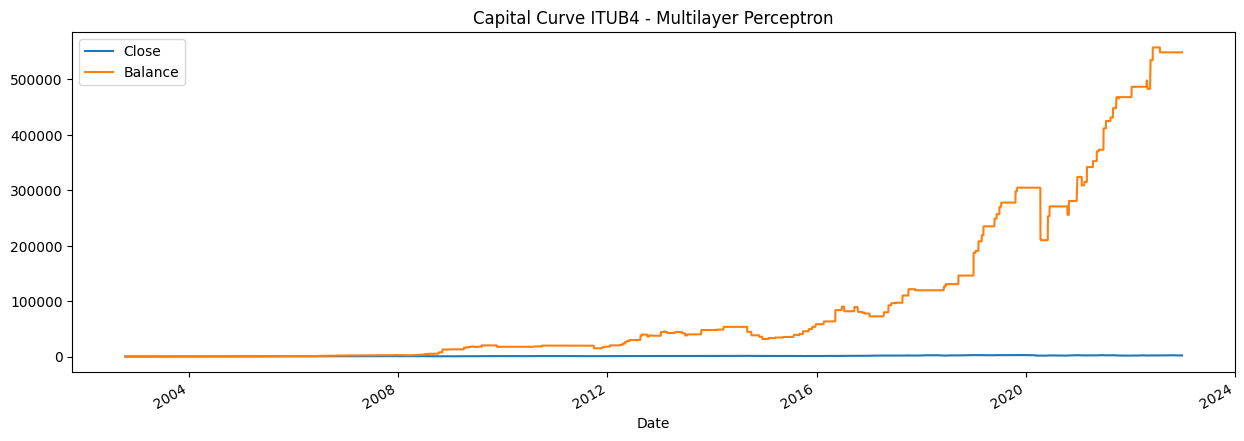

In [106]:
eval_trade_result(df_itub4, 100, 'ITUB4', 'Multilayer Perceptron')

#### Classificador Random Forest

In [107]:
rf = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=5)
train(input_data, output_data, rf, df_itub4)

Train's mean accuracy:  0.9
Test's mean accuracy:  0.72


Total Trades: 81, Green trades: 66 (81.48%)
Green trades's mean return: 12.76%, Red trades's mean return: -8.66%
Rentability buy and hold: 1958.06%, Rentability ML trade: 48270.07%



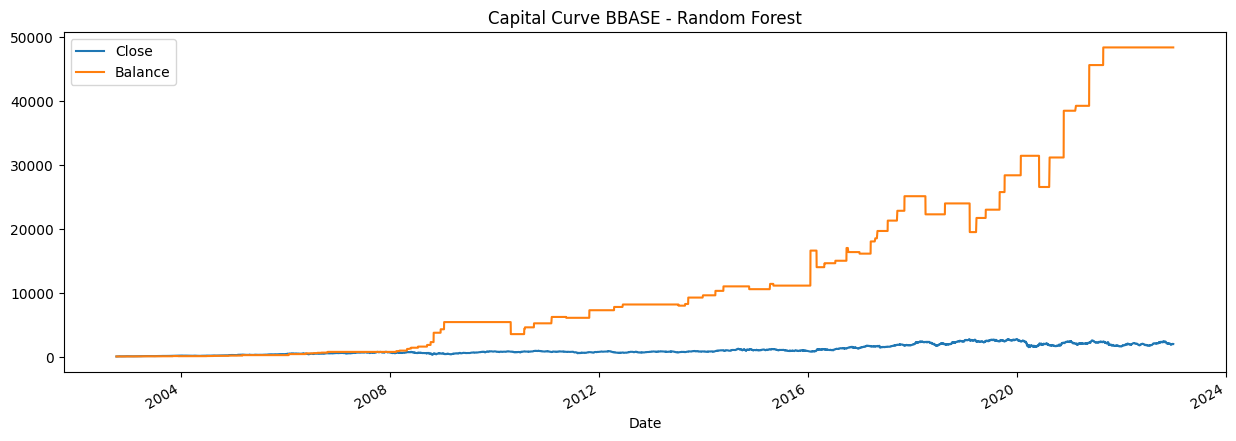

In [108]:
eval_trade_result(df_itub4, 100, 'BBASE', 'Random Forest')

## Banco do Brasil - BBAS3


#### Obtenção dos Dados de Entrada e Saída

In [109]:
input_data = get_input_params(df_bbas3)
output_data = get_output_params(df_bbas3)

print(f"## INPUT SIZE: {input_data.shape} ##\n## OUTPUT SIZE: {output_data.shape} ##")

## INPUT SIZE: (5055, 3) ##
## OUTPUT SIZE: (5055, 1) ##


#### Classificador Multilayer Perceptron

In [110]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(15, ), max_iter=1000000, random_state=1, activation='tanh')
train(input_data, output_data, mlp, df_bbas3)

Train's mean accuracy:  0.91
Test's mean accuracy:  0.68


Total Trades: 143, Green trades: 103 (72.03%)
Green trades's mean return: 12.42%, Red trades's mean return: -8.1%
Rentability buy and hold: 2685.79%, Rentability ML trade: 265871.32%



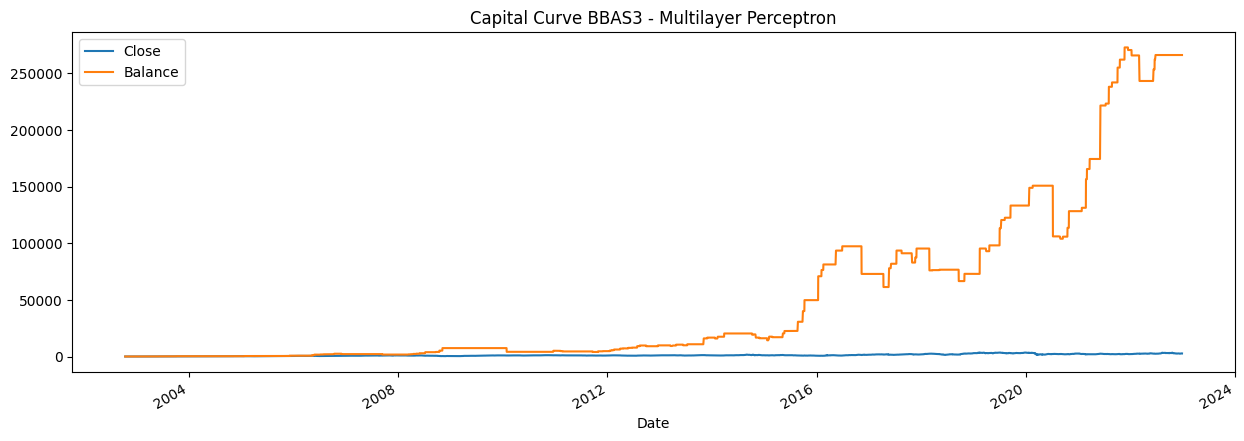

In [111]:
eval_trade_result(df_bbas3, 100, 'BBAS3', 'Multilayer Perceptron')

#### Classificador Random Forest

In [112]:
rf = RandomForestClassifier(random_state=1, max_depth=7, n_estimators=5)
train(input_data, output_data, rf, df_bbas3)

Train's mean accuracy:  0.89
Test's mean accuracy:  0.77


Total Trades: 70, Green trades: 58 (82.86%)
Green trades's mean return: 19.49%, Red trades's mean return: -11.68%
Rentability buy and hold: 2685.79%, Rentability ML trade: 366016.64%



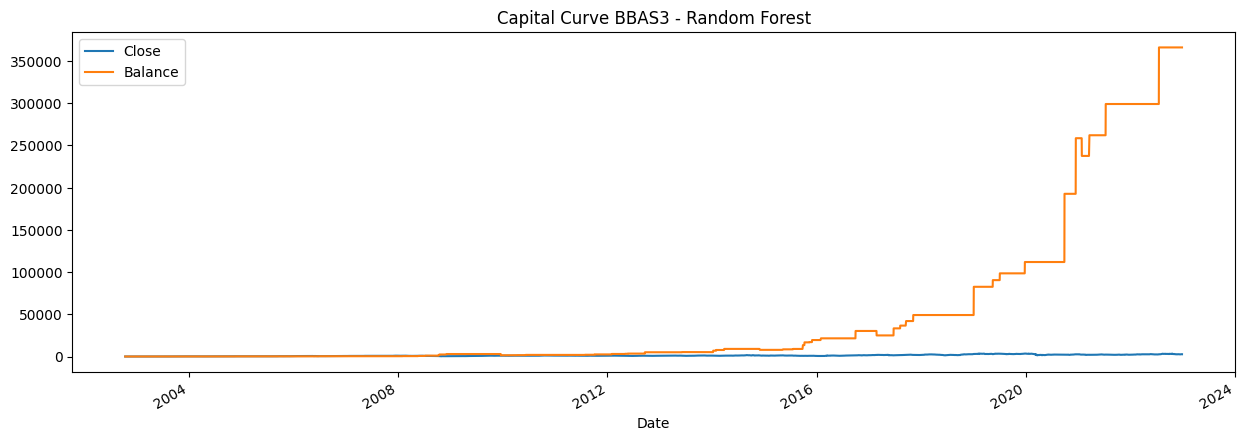

In [113]:
eval_trade_result(df_bbas3, 100, 'BBAS3', 'Random Forest')